In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
%matplotlib inline

In [2]:
# load positive labels
pos = open('Dataset/IRAhandle_tweets_1.csv').read()
npos = 0
labels, texts = [], []
for i, line in enumerate(pos.split("\n")):
    content = line.split(',')
    if len(content) < 4:
    	continue;
    if content[4] != "English":
    	continue;
    labels.append(1)
    texts.append(content[2])
    npos += 1

# load negative labels (random tweets)
neg = open('Dataset/Negative_tweets(10000).txt').read()
nneg = 0
for i, line in enumerate(neg.split("\n")):
    labels.append(0)
    texts.append(line)
    nneg += 1

texts, labels = shuffle(texts, labels)

print('Total number of datapoints: ', len(labels))
print('Positive labels: ', npos)
print('Negative labels: ', nneg)

df = pd.DataFrame()
df['text'] = texts
df['label'] = labels

df.head()

Total number of datapoints:  162536
Positive labels:  154563
Negative labels:  7973


,text,label
0,Dozens forced to evacuate after flooding at Sn...,1
1,Corruption In Politics Went To A Whole New Lev...,1
2,Richard Shelby’s next water wars move for Alab...,1
3,"""'@dubbedbass @Fuctupmind @wikileaks Did u kno...",1
4,Workshop this Sat. on the state of the #deathp...,1


/home/serinetrader/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Breakdown by label type')

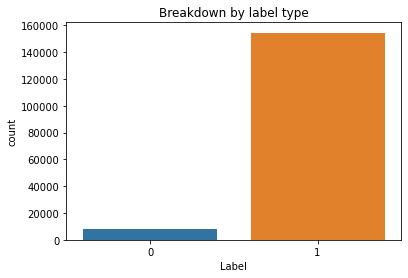

In [3]:
sns.countplot(df.label)
plt.xlabel('Label')
plt.title('Breakdown by label type')

In [4]:
enc = LabelEncoder()
y = enc.fit_transform(labels).reshape(-1,1)
train_x, test_x, train_y, test_y = train_test_split(df['text'], y, test_size=0.20)

# Tokenize the text. Max length 280 (may tweak)

maxlen = 280
maxwords = 10000

token = Tokenizer(num_words=maxwords)
token.fit_on_texts(df['text'])

sequences = token.texts_to_sequences(train_x)
print(sequences)
padded = sequence.pad_sequences(sequences, maxlen=maxlen)

In [5]:
def lstm_model():
    inputs = Input(name='inputs',shape=[maxlen])
    layer = Embedding(maxwords,50,input_length=maxlen)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = lstm_model()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 280)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 280, 50)           500000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257   

In [6]:
history = model.fit(padded,train_y,epochs=10,
          validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
3251/3251 [==============================] - 37449s 12s/step - loss: 0.1520 - accuracy: 0.9523 - val_loss: 0.0897 - val_accuracy: 0.9668
Epoch 2/10
3251/3251 [==============================] - 397s 121ms/step - loss: 0.0825 - accuracy: 0.9691 - val_loss: 0.0830 - val_accuracy: 0.9686
Epoch 3/10
3251/3251 [==============================] - 511s 157ms/step - loss: 0.0749 - accuracy: 0.9724 - val_loss: 0.0782 - val_accuracy: 0.9694
Epoch 4/10
3251/3251 [==============================] - 471s 145ms/step - loss: 0.0742 - accuracy: 0.9740 - val_loss: 0.0846 - val_accuracy: 0.9689


In [7]:
test_sequences = token.texts_to_sequences(test_x)
test_padded = sequence.pad_sequences(test_sequences,maxlen=maxlen)

accuracy = model.evaluate(test_padded, test_y)
print('Test loss: ', accuracy[0])
print('Test accuracy: ', accuracy[1])



1016/1016 [==============================] - 37s 37ms/step - loss: 0.0817 - accuracy: 0.9703
Test loss:  0.0816890299320221
Test accuracy:  0.9702842235565186


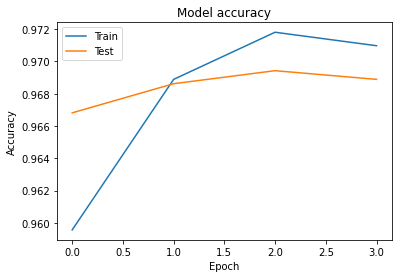

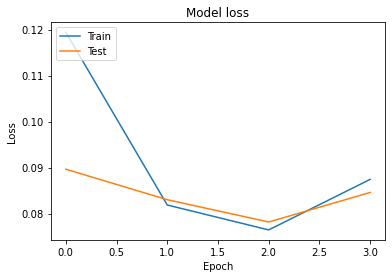

In [8]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()